<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/voting_regressor/2.model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [26]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

# Grid search
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [3]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

# Import module files

In [4]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}


files = [
    'path_manager.py',
    'sklearn_utils.py',
    'sklearn_transformers.py',
    'model.py'
]

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/main/'
url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [27]:
import importlib
import path_manager
import sklearn_transformers
import sklearn_utils
import model

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils,
        sklearn_transformers,
        model
    ]
)

from path_manager import PathManager

from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import nan_statistics
from sklearn_utils import visualize_datasets_distributions
from sklearn_utils import print_model_cv_scores
from sklearn_utils import plot_cv_results
from sklearn_utils import fit_grid_search
from sklearn_utils import fit_randomized_search
from sklearn_utils import dict_subset

from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
from model import Model

# Fixing seed

In [6]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Setup paths (**Set preprocessing and model trials!**)

In [7]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'
PREPROC_TRIAL = 4
MODELS_TRIAL = 4

Mounted at /content/gdrive


In [8]:
manager = PathManager(
    competition_path=COMPETITION_PATH, 
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Data/preproc_trial_4 already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_4 already exists


# Download the data

In [9]:
kaggle_test_path = os.path.join(
    manager.data_trial_path,
    'test_processed.csv'
)
df_test = pd.read_csv(
    kaggle_test_path, index_col=[0]
)
df_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,0.000000,0.461538,0.533333,0.222222,0.000000,0.111111,0.444444,0.333333,0.166667,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.181818,0.461538,0.533333,0.222222,0.142857,0.111111,0.444444,0.222222,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
df_test_sample = pd.read_csv(
    os.path.join(manager.data_trial_path, 'test_sample_processed.csv'), 
    index_col=[0]
)
df_test_sample.head(2)

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,0.000000,0.153846,0.666667,0.0,0.0,0.111111,0.000000,0.444444,0.166667,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,14.842280
1,0.272727,0.615385,0.533333,0.0,0.0,0.222222,0.444444,0.444444,0.166667,0.166667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15.312391


In [11]:
df_trainval = pd.read_csv(
    os.path.join(manager.data_trial_path, 'trainval_sample_processed.csv'), 
    index_col=[0]
)
df_trainval.head(2)

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,0.181818,0.461538,0.4,0.222222,0.142857,0.111111,0.444444,0.444444,0.166667,0.166667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15.278005
1,0.090909,0.461538,0.4,0.444444,0.428571,0.444444,0.444444,0.333333,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15.255171


In [12]:
X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

In [13]:
X_test_sample = df_test_sample.values[:, :-1]  # test subsample from training data
Y_test_sample = df_test_sample.values[:, -1]

# Select and train models (+ ensemble methods)

## Define models

In [100]:
from sklearn.ensemble import ExtraTreesRegressor

ExtraTreesModel = Model(
    ExtraTreesRegressor(),
    'Extra trees',
    [
        {
            'n_estimators': [2, 3, 5],
            'max_depth': [1, 3, 5],
            'max_features': ['sqrt', 'log2', 0.5, 1.0]
        }
    ],
    [
        # Empty
    ]
)

In [97]:
RFModel = Model(
    RandomForestRegressor(),
    'RF',
    [
        {
            'n_estimators': [1, 2],
            'max_depth': [1, 2],
            'random_state': [42],
            'max_features': ['sqrt', 'log2', 0.5, 0.7]
        }
    ],

    [
        {
            'n_estimators': [i * 1 for i in range(1, 11)],
            'max_depth': [i for i in range(1, 11)],
            'bootstrap': [True],
            'max_samples': [0.4, 0.6, 0.9],
            'min_samples_split': [i for i in range(2, 10)],
            'max_features': ['sqrt', 'log2'],
            'random_state': [42]
        }
    ]
)

ElasticNetModel = Model(
    ElasticNet(),
    'ElasticNet',
    [
        {
            'alpha': [0.05, 0.1, 0.3, 0.5],
            'l1_ratio': [0.1, 0.2, 0.5],
            'random_state': [42]
        }, 
    ],
    [
        {
            'alpha': [i * 0.05 for i in range(1, 10)],
            'l1_ratio': [i * 0.08 for i in range(1, 10)],
            'random_state': [42]
        }
    ]
)

SVRModel = Model(
    SVR(),
    'SVM reg',
    [
        {
            'kernel': ['linear'],
            'C': [0.2, 0.5, 1.0]
        },
     
        {
            'kernel': ['rbf', 'sigmoid', 'poly'],
            'gamma': ['scale', 'auto'],
            'C': [0.2, 0.5, 1.0]
        }
    ],
    [
        {
            'kernel': ['linear'],
            'C': [0.1 * i for i in range(1, 11)]
        },
        {
            'kernel': ['rbf', 'sigmoid', 'poly'],
            'gamma': ['scale', 'auto'],
            'C': [0.1 * i for i in range(1, 11)]
        }
    ]
)

In [101]:
XGBModel = Model(
    GradientBoostingRegressor(n_estimators=5),
    'XGB',
    [
        {
            'n_estimators': [1, 2, 3],
            'max_depth': [1, 2, 3],
            'learning_rate': [0.1, 0.01, 0.003],
            'subsample': [0.5, 0.7, 0.9, 1.0],
            'max_features': ['auto', 'sqrt', 'log2'],
            'random_state': [42]
        }
    ],
    [
        {
            'n_estimators': [i for i in range(1, 9)],
            'max_depth': [i for i in range(1, 10)],
            'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
            'subsample': [i * 0.1 for i in range(4, 10)],
            'min_samples_leaf': [i for i in range(1, 10)],
            'max_features': ['auto', 'sqrt', 'log2'],
            'random_state': [42]
        }
    ]
)

pep8(_ih)

In [104]:
all_models = {
    model.name: model for model in [
        RFModel, 
        SVRModel,
        ElasticNetModel,
        XGBModel,
        ExtraTreesModel
    ]
}

## Preliminary look. Shortlisting 2-5 models, based on CV results, overfitting tendency

Model          Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-----------  ----------------------  ----------------  ------------------------  ------------------
Extra trees             -0.00589991        0.00373159                 -0.278238           0.106083
RF                      -0.0378215         0.00425959                 -0.244145           0.089132
SVM reg                 -0.12911           0.0151081                  -0.240258           0.104099
XGB                     -0.167867          0.0144129                  -0.240175           0.0895741
ElasticNet              -0.231301          0.0163317                  -0.238785           0.102111


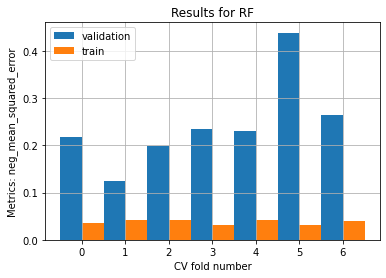

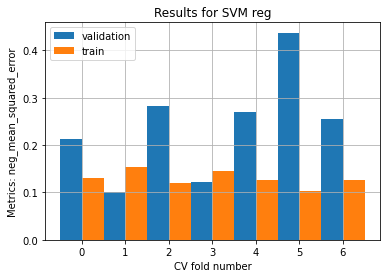

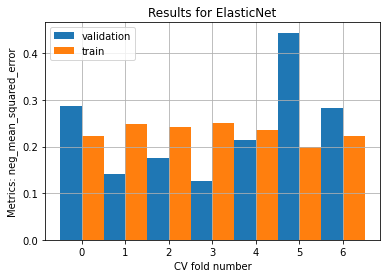

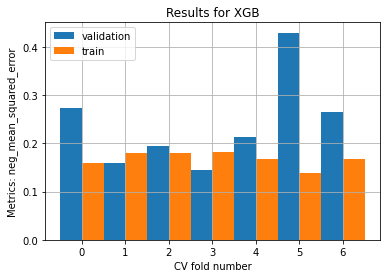

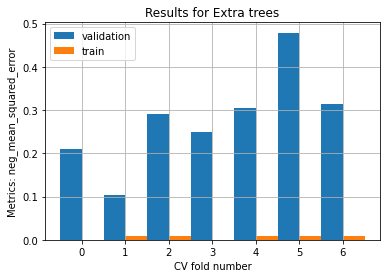

In [105]:
# %%pycodestyle
np.random.seed(RANDOM_SEED)

res = plot_cv_results(
    sklearn_models_dict_={
        model_name: model.model for model_name, model in all_models.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

In [106]:
shortlisted_models = {
    model.name: model for model in [
        # RFModel,
        ExtraTreesModel,
        ElasticNetModel, 
        SVRModel,
        XGBModel
    ]
}

# Fine tuning

## Grid search

In [107]:
shortlisted_models.keys()

dict_keys(['Extra trees', 'ElasticNet', 'SVM reg', 'XGB'])

In [108]:
elastic_grid_search_results = fit_grid_search(
    dict_subset(shortlisted_models, ['ElasticNet']),
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=4,
    scoring_='neg_mean_squared_error'
)

pep8(_ih)

Fitting ElasticNet



In [110]:
elastic_grid_search_results['ElasticNet'].best_score_

-0.2107666528079753

In [114]:
extra_trees_gs_results = fit_grid_search(
    dict_subset(shortlisted_models, ['Extra trees']),
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=4,
    scoring_='neg_mean_squared_error'
)

extra_trees_gs_results['Extra trees'].best_score_

Fitting Extra trees


-0.2011730028056335

In [115]:
rf_gs_results = fit_grid_search(
    dict_subset(all_models, ['RF']),
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=6,
    scoring_='neg_mean_squared_error'
)

rf_gs_results['RF'].best_score_

Fitting RF


-0.2192165449474854

In [116]:
rest_gs_results = fit_grid_search(
    dict_subset(shortlisted_models, ['SVM reg', 'XGB']),
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=4,
    scoring_='neg_mean_squared_error'
)



Fitting SVM reg
Fitting XGB


In [117]:
grid_search_results = {
    **rest_gs_results,
    **elastic_grid_search_results,
    **rf_gs_results,
    **extra_trees_gs_results
}


for estimator in grid_search_results.values():
    print(estimator.best_estimator_)

SVR(C=0.2)
GradientBoostingRegressor(max_features='sqrt', n_estimators=3, random_state=42,
                          subsample=0.5)
ElasticNet(alpha=0.05, l1_ratio=0.2, random_state=42)
RandomForestRegressor(max_depth=1, max_features='sqrt', n_estimators=2,
                      random_state=42)
ExtraTreesRegressor(max_depth=3, max_features='log2', n_estimators=5)


## Randomized search

In [58]:
rand_search_results = fit_randomized_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=6,
    n_iter_=10,
    scoring_='neg_mean_squared_error'
)

Fitting ElasticNet
Fitting SVM reg
Fitting XGB


In [59]:
# print(rand_search_results.get('RF').best_estimator_)
# print(rand_search_results['SVM reg'].best_estimator_)
rand_search_results['ElasticNet'].best_estimator_

ElasticNet(alpha=0.1, l1_ratio=0.16, random_state=42)

# Check final models for overfit

Model         Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
----------  ----------------------  ----------------  ------------------------  ------------------
XGB                      -0.190162         0.0118472                 -0.225101            0.127273
SVM reg                  -0.186568         0.0129498                 -0.216554            0.12302
ElasticNet               -0.205893         0.0137169                 -0.216432            0.126465


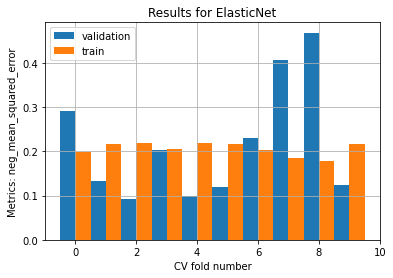

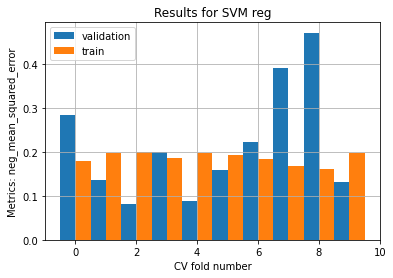

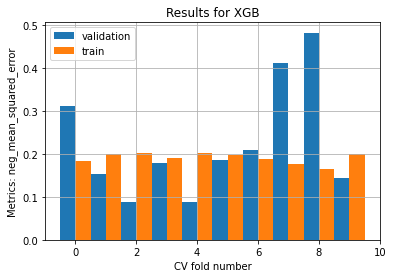

In [60]:
_ = plot_cv_results(
    sklearn_models_dict_ = {
        model_name: result.best_estimator_
        for model_name, result in rand_search_results.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=10,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

Model          Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-----------  ----------------------  ----------------  ------------------------  ------------------
XGB                       -0.204879         0.0183952                 -0.228868           0.069505
RF                        -0.216699         0.0114704                 -0.219217           0.0706041
SVM reg                   -0.172008         0.0126294                 -0.215033           0.0722789
ElasticNet                -0.197838         0.0137353                 -0.214132           0.0738751
Extra trees               -0.177346         0.0148522                 -0.212556           0.0687454


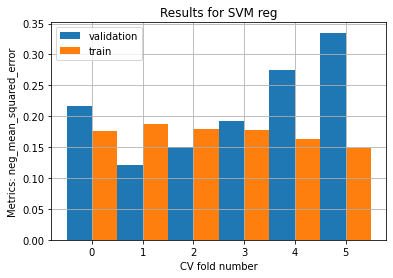

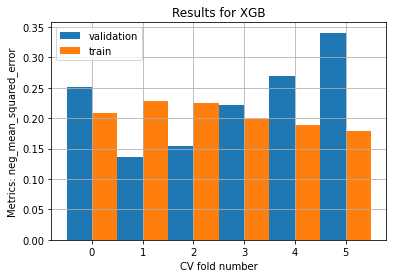

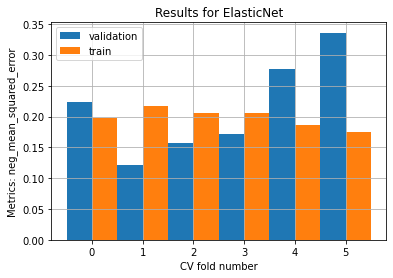

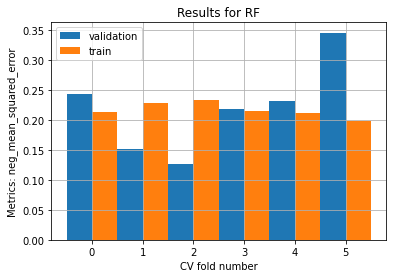

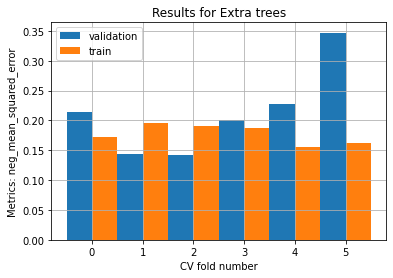

In [118]:
_ = plot_cv_results(
    sklearn_models_dict_ = {
        model_name: result.best_estimator_
        for model_name, result in grid_search_results.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=6,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

# Stacking for best estimators

In [120]:
{
    name: model.best_estimator_
    for name, model in grid_search_results.items()
}

{'SVM reg': SVR(C=0.2),
 'XGB': GradientBoostingRegressor(max_features='sqrt', n_estimators=3, random_state=42,
                           subsample=0.5),
 'ElasticNet': ElasticNet(alpha=0.05, l1_ratio=0.2, random_state=42),
 'RF': RandomForestRegressor(max_depth=1, max_features='sqrt', n_estimators=2,
                       random_state=42),
 'Extra trees': ExtraTreesRegressor(max_depth=3, max_features='log2', n_estimators=5)}

In [126]:
from sklearn.ensemble import VotingRegressor

VotingModel = Model(
    VotingRegressor(
        estimators=\
        [   
            (model_name, model.best_estimator_) 
            for model_name, model
            in dict_subset(
                grid_search_results, 
                [
                'XGB', 
                'ElasticNet', 
                'Extra trees'
                ]
            ).items()
        ]
    ),
    'Voting regressor',
    [
        # Empty grid search parameters
    ],
    [
        # Empty randomized search parameters
    ]
)

In [130]:
VotingModel.model.fit(X_train_val, Y_train_val)

VotingRegressor(estimators=[('XGB',
                             GradientBoostingRegressor(max_features='sqrt',
                                                       n_estimators=3,
                                                       random_state=42,
                                                       subsample=0.5)),
                            ('ElasticNet',
                             ElasticNet(alpha=0.05, l1_ratio=0.2,
                                        random_state=42)),
                            ('Extra trees',
                             ExtraTreesRegressor(max_depth=3,
                                                 max_features='log2',
                                                 n_estimators=5))])

Model               Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
----------------  ----------------------  ----------------  ------------------------  ------------------
Voting regressor               -0.189697         0.0131119                 -0.219469            0.129341


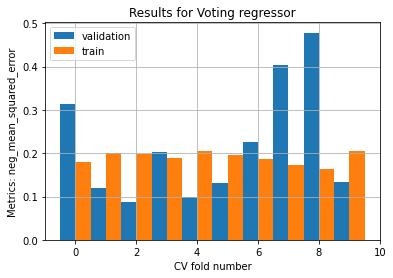

In [129]:
_ = plot_cv_results(
    {
        'Voting regressor': VotingModel.model
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=10,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

# Saving fine tuned candidates (retrained on train+val subset)

In [131]:
manager.save_models(
    {
        'Voting reg': VotingModel.model
    }
)

In [134]:
manager.save_models(
    {
        f'{model_name}_gs': estimator.best_estimator_ for model_name, estimator
        in grid_search_results.items()
    }
)

/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_4/SVM reg_gs already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_4/XGB_gs already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_4/ElasticNet_gs already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_4/RF_gs already exists
/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_4/Extra trees_gs already exists


In [ ]:
manager.save_models(
    {
        f'{model_name}_rand': result.best_estimator_
        for model_name, result in rand_search_results.items()
    }
)